# Demo

Author: Cindy Chiao

## What is xbatcher? 
Xbatcher is a small library for iterating through xarray objects (DataArrays and Datasets) in batches. The goal is to make it easy to feed xarray objects to machine learning libraries such as Keras and PyTorch. 

## What is included in this notebook?
* showcase current abilities with example data 
* brief discussion of current development track and ideas for future work 

In [1]:
import xarray as xr
import xbatcher

## Example data

Here we will load an example dataset from a global climate model. The data is from the _historical_ experiment from CMIP6 and represents 60 days of daily max air temperature. 

In [2]:
store = "az://carbonplan-share/example_cmip6_data.zarr"
ds = xr.open_dataset(
    store,
    engine="zarr",
    chunks={},
    backend_kwargs={"storage_options": {"account_name": "carbonplan"}},
)

# the attributes contain a lot of useful information, but clutter the print out when we inspect the outputs
# throughout this demo, clearing it to avoid confusion
ds.attrs = {}

# inspect the dataset
ds

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 60)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 1850-03-01T12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(60, 145, 192), meta=np.ndarray>

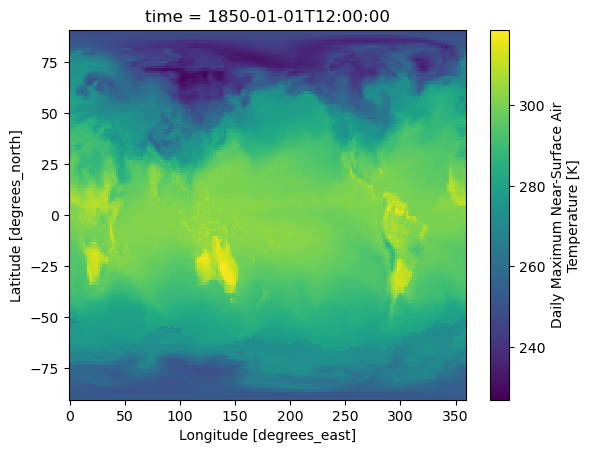

In [3]:
# plot the first time dimension
ds.isel(time=0).tasmax.plot();

## Batch generation

Xbatcher's `BatchGenerator` can be used to generate batches with several arguments controlling the exact behavior.

The `input_dims` argument takes a dictionary specifying the size of the inputs in each dimension. For example, `{'time': 10}` means that each of the input sample will have 10 time points, while all other dimensions are flattened to a "sample" dimension

Note that even though `ds` in this case only has one variable, the function can operate on multiple variables at the same time.

In [4]:
n_timepoint_in_each_sample = 10

bgen = xbatcher.BatchGenerator(
    ds=ds,
    input_dims={"time": n_timepoint_in_each_sample},
)

print(f"{len(bgen)} batches")

6 batches


In [5]:
batch = bgen[0]
batch

<xarray.Dataset>
Dimensions:  (time: 10, sample: 27840)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 1850-01-10T12:00:00
  * sample   (sample) object MultiIndex
  * lat      (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon      (sample) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Data variables:
    tasmax   (sample, time) float32 252.6 250.9 250.4 ... 240.6 234.6 233.4

We can verify that the outputs have the expected shapes. 

For example, there are 60 time points in our input dataset, we're asking 10 timepoints in each batch, thus expecting 6 batches 

In [6]:
expected_n_batch = len(ds.time) / n_timepoint_in_each_sample
print(f"Expecting {expected_n_batch} batches, getting {len(bgen)} batches")

Expecting 6.0 batches, getting 6 batches


There are 145 lat points and 192 lon points, thus we're expecting 145 * 192 = 27840 samples in a batch.

In [7]:
expected_batch_size = len(ds.lat) * len(ds.lon)
print(
    f"Expecting {expected_batch_size} samples per batch, getting {len(batch.sample)} samples per batch"
)

Expecting 27840 samples per batch, getting 27840 samples per batch


## Controlling the size/shape of batches

We can use `batch_dims` and `concat_input_dims` options to control how many sample ends up in each batch. For example, we can specify 10 time points for each sample, but 20 time points in each batch this should yield half as many batches and twice as many samples in a batch as the example above note the difference in dimension name in this case 

In [8]:
n_timepoint_in_each_sample = 10
n_timepoint_in_each_batch = 20

bgen = xbatcher.BatchGenerator(
    ds=ds,
    input_dims={"time": n_timepoint_in_each_sample},
    batch_dims={"time": n_timepoint_in_each_batch},
    concat_input_dims=True,
)

print(f"{len(bgen)} batches")

3 batches


In [9]:
bgen[0]

<xarray.Dataset>
Dimensions:      (time_input: 10, sample: 55680)
Coordinates:
    time         (sample, time_input) datetime64[ns] 1850-01-01T12:00:00 ... ...
  * sample       (sample) object MultiIndex
  * lat          (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  * lon          (sample) float64 0.0 0.0 1.875 1.875 ... 356.2 358.1 358.1
  * input_batch  (sample) int64 0 1 0 1 0 1 0 1 0 1 0 ... 1 0 1 0 1 0 1 0 1 0 1
Dimensions without coordinates: time_input
Data variables:
    tasmax       (sample, time_input) float32 252.6 250.9 250.4 ... 238.9 241.0

## Last batch behavior

If the input ds is not divisible by the specified `input_dims`, the remainder will be discarded instead of having a fractional batch. See https://github.com/xarray-contrib/xbatcher/issues/5 for more on this topic.

In [10]:
n_timepoint_in_batch = 31

bgen = xbatcher.BatchGenerator(ds=ds, input_dims={"time": n_timepoint_in_batch})

for batch in bgen:
    print(f"last time point in ds    is {ds.time[-1].values}")
    print(f"last time point in batch is {batch.time[-1].values}")
batch

last time point in ds    is 1850-03-01T12:00:00.000000000
last time point in batch is 1850-01-31T12:00:00.000000000


<xarray.Dataset>
Dimensions:  (time: 31, sample: 27840)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 1850-01-31T12:00:00
  * sample   (sample) object MultiIndex
  * lat      (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon      (sample) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Data variables:
    tasmax   (sample, time) float32 252.6 250.9 250.4 ... 257.6 256.9 243.3

## Overlapping inputs

In the example above, all samples have distinct time points. That is, for any lat/lon pixel, sample 1 has time points 1-10, sample 2 has time point 11-20, and they do not overlap 
however, in many machine learning applications, we will want overlapping samples (e.g. sample 1 has time points 1-10, sample 2 has time points 2-11, and so on). We can use the `input_overlap` argument to get this behavior.

In [11]:
n_timepoint_in_each_sample = 10
n_timepoint_in_each_batch = 20
input_overlap = 9

bgen = xbatcher.BatchGenerator(
    ds=ds,
    input_dims={"time": n_timepoint_in_each_sample},
    batch_dims={"time": n_timepoint_in_each_batch},
    concat_input_dims=True,
    input_overlap={"time": input_overlap},
)

batch = bgen[0]

print(f"{len(bgen)} batches")
batch

3 batches


<xarray.Dataset>
Dimensions:      (time_input: 10, sample: 306240)
Coordinates:
    time         (sample, time_input) datetime64[ns] 1850-01-01T12:00:00 ... ...
  * sample       (sample) object MultiIndex
  * lat          (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  * lon          (sample) float64 0.0 0.0 0.0 0.0 ... 358.1 358.1 358.1 358.1
  * input_batch  (sample) int64 0 1 2 3 4 5 6 7 8 9 10 ... 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: time_input
Data variables:
    tasmax       (sample, time_input) float32 252.6 250.9 250.4 ... 238.9 241.0

We can inspect the samples in a batch for a lat/lon pixel, noting that the overlap only applies within a batch and not across. Thus, within the 20 time points in a batch, we can get 11 samples each with 10 time points and 9 time points allowed to overlap.

In [12]:
lat = -90
lon = 0
pixel = batch.sel(lat=lat, lon=lon)
display(pixel)

print(
    f"sample 1 goes from {pixel.isel(input_batch=0).time[0].values} to {pixel.isel(input_batch=0).time[-1].values}"
)
print(
    f"sample 2 goes from {pixel.isel(input_batch=1).time[0].values} to {pixel.isel(input_batch=1).time[-1].values}"
)

<xarray.Dataset>
Dimensions:      (input_batch: 11, time_input: 10)
Coordinates:
    time         (input_batch, time_input) datetime64[ns] 1850-01-01T12:00:00...
  * input_batch  (input_batch) int64 0 1 2 3 4 5 6 7 8 9 10
    lat          float64 -90.0
    lon          float64 0.0
Dimensions without coordinates: time_input
Data variables:
    tasmax       (input_batch, time_input) float32 252.6 250.9 ... 243.4 243.7

sample 1 goes from 1850-01-01T12:00:00.000000000 to 1850-01-10T12:00:00.000000000
sample 2 goes from 1850-01-02T12:00:00.000000000 to 1850-01-11T12:00:00.000000000


## Example applications

These batches can then be used to train a downstream machine learning model while preserving the indices of these sample. 

As an example, let's say we want to train a simple CNN model to predict the max air temprature for each day at each lat/lon pixel. To predict the temperature at lat/lon/time of (i, j, t), we'll use features including the temperature of a 9 x 9 grid centered at (i, j), from times t-10 to t-1 (shape of input should be (n_samples_in_each_batch, 9, 9, 9)). Note that in this example, we subset the dataset to a smaller domain for efficiency.

In [13]:
bgen = xbatcher.BatchGenerator(
    ds=ds[["tasmax"]].isel(lat=slice(0, 18), lon=slice(0, 18), time=slice(0, 30)),
    input_dims={"lat": 9, "lon": 9, "time": 10},
    batch_dims={"lat": 18, "lon": 18, "time": 15},
    concat_input_dims=True,
    input_overlap={"lat": 8, "lon": 8, "time": 9},
)

for i, batch in enumerate(bgen):
    print(f"batch {i}")
    # make sure the ordering of dimension is consistent
    batch = batch.transpose("input_batch", "lat_input", "lon_input", "time_input")

    # only use the first 9 time points as features, since the last time point is the label to be predicted
    features = batch.tasmax.isel(time_input=slice(0, 9))
    # select the center pixel at the last time point to be the label to be predicted
    # the actual lat/lon/time for each of the sample can be accessed in labels.coords
    labels = batch.tasmax.isel(lat_input=5, lon_input=5, time_input=9)

    print("feature shape", features.shape)
    print("label shape", labels.shape)
    print("shape of lat of each sample", labels.coords["lat"].shape)
    print("")

batch 0
feature shape (600, 9, 9, 9)
label shape (600,)
shape of lat of each sample (600,)

batch 1
feature shape (600, 9, 9, 9)
label shape (600,)
shape of lat of each sample (600,)



We can also use the Xarray's "stack" method to transform these into 2D inputs (n_samples, n_features) suitable for other machine learning algorithms implemented in libraries such as [sklearn](https://scikit-learn.org/stable/) and [xgboost](https://xgboost.readthedocs.io/en/stable/). In this case, we are expecting 9 x 9 x 9 = 729 features total.

In [14]:
for i, batch in enumerate(bgen):
    print(f"batch {i}")
    # make sure the ordering of dimension is consistent
    batch = batch.transpose("input_batch", "lat_input", "lon_input", "time_input")

    # only use the first 9 time points as features, since the last time point is the label to be predicted
    features = batch.tasmax.isel(time_input=slice(0, 9))
    features = features.stack(features=["lat_input", "lon_input", "time_input"])

    # select the center pixel at the last time point to be the label to be predicted
    # the actual lat/lon/time for each of the sample can be accessed in labels.coords
    labels = batch.tasmax.isel(lat_input=5, lon_input=5, time_input=9)

    print("feature shape", features.shape)
    print("label shape", labels.shape)
    print("shape of lat of each sample", labels.coords["lat"].shape, "\n")

batch 0
feature shape (600, 729)
label shape (600,)
shape of lat of each sample (600,) 

batch 1
feature shape (600, 729)
label shape (600,)
shape of lat of each sample (600,) 



## What's next?

There are many additional useful features that were yet to be implemented in the context of batch generation for downstream machine learning model training purposes. One of the current efforts is to improve the set of data loaders. 

Additional features of interest can include: 

1. Handling overlaps across batches. The common use case of batching in machine learning training involves generating all samples, then group them into batches. When overlap is enabled, this yields different results compared to first generating batches then creating possible samples within each batch. 

2. Shuffling/randomization of samples across batches. It is often desirable for each batch to be grouped randomly instead of along a specific dimension. 

3. Be efficient in terms of memory usage. In the case where overlap is enabled, each sample would comprised of mostly repetitive values compared to adjacent samples. It would be beneficial if each batch/sample is generated lazily to avoid storing these extra duplicative values. 

4. Handling preprocessing steps. For example, data augmentation, scaling/normalization, outlier detection, etc. 


More thoughts on 1. and 2. can be found in [this issue](https://github.com/xarray-contrib/xbatcher/issues/30). Interested users are welcomed to comment or submit other issues in GitHub. 

In [15]:
%load_ext watermark
%watermark -iv

xbatcher: 0.1.0.post96
xarray  : 2022.10.0

